# Visualize LIBERO Dataset

Libraries

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D proj)
from mpl_toolkits.mplot3d import art3d  # Line3DCollection lives here

2025-07-22 16:44:24.601186: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 16:44:24.604580: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-22 16:44:24.613115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753202664.626904   11953 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753202664.630960   11953 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753202664.642674   11953 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Load Dataset

In [33]:
tfrecord_dir = "/home/ubuntu/vla/data/modified_libero_rlds/libero_spatial_no_noops/1.0.0"
# tfrecord_dir = "/home/ubuntu/vla/data/closed_gripper_libero_rlds/libero_spatial_no_noops/1.0.0"
tfrecord_paths = [
    os.path.join(tfrecord_dir, f)
    for f in sorted(os.listdir(tfrecord_dir))
    if ".tfrecord" in f
]
tfrecord_paths

['/home/ubuntu/vla/data/modified_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00000-of-00016',
 '/home/ubuntu/vla/data/modified_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00001-of-00016',
 '/home/ubuntu/vla/data/modified_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00002-of-00016',
 '/home/ubuntu/vla/data/modified_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00003-of-00016',
 '/home/ubuntu/vla/data/modified_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00004-of-00016',
 '/home/ubuntu/vla/data/modified_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00005-of-00016',
 '/home/ubuntu/vla/data/modified_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00006-of-00016',
 '/home/ubuntu/vla/data/modified_libero_rlds/libero_spatial_no_noops/1.0.0/libero_spatial-train.tfrecord-00007-of-00016',
 '/home/ubuntu/vla/data/

In [35]:
# === Load all episodes into a list first ===
raw_dataset = list(tf.data.TFRecordDataset(tfrecord_paths))
total_episodes = len(raw_dataset)
print(f"Total episodes in file: {total_episodes}")

Total episodes in file: 432


Gather Trajectories

[Success] Saved plot to all_trajectories_xyz.png


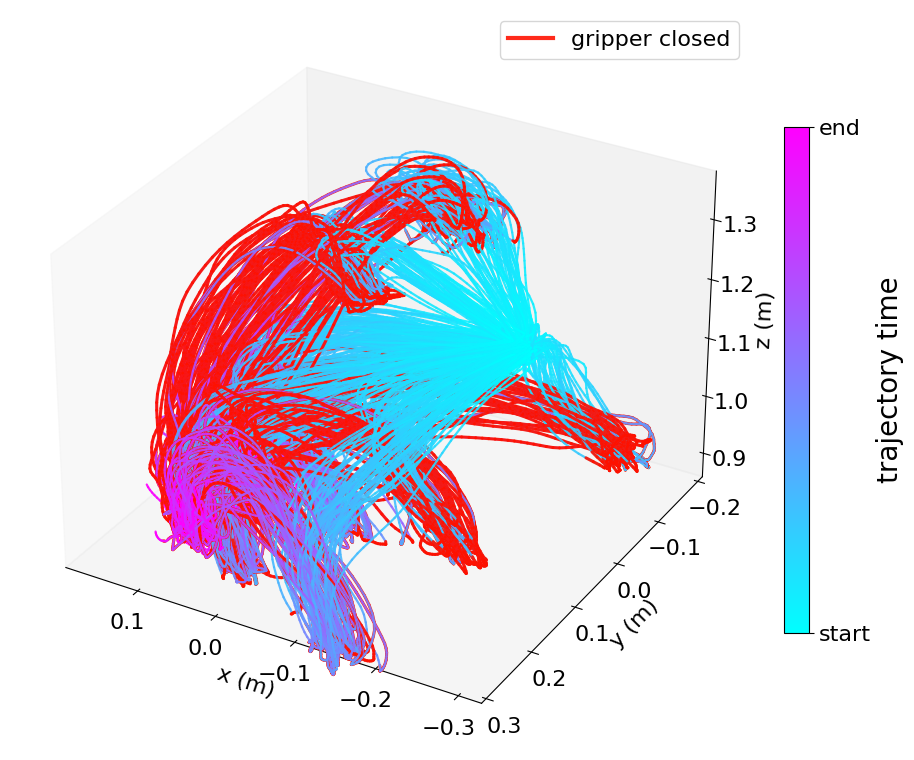

In [36]:
# --- knobs ---
TEXT_SIZE = 20
# Closed gripper when action[-1] == 1.0
OVERLAY_GRIPPER_CLOSE = True          # <== turn overlay on/off here
SUNSET_ORANGE = "#FF1100E4"             # sunset-ish orange

def get_xyz_position_from_episode(context):
    state_flat = context["steps/observation/state"].float_list.value
    state = np.asarray(state_flat, dtype=np.float32).reshape(-1, 8)
    return state[:, :3]

def get_actions_from_episode(context):
    action_flat = context["steps/action"].float_list.value
    return np.asarray(action_flat, dtype=np.float32).reshape(-1, 7)

def set_axes_equal(ax):
    xlim, ylim, zlim = ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()
    ranges = np.array([xlim, ylim, zlim])
    centers = ranges.mean(axis=1)
    max_range = (ranges[:,1] - ranges[:,0]).max() / 3
    ax.set_xlim3d([centers[0]-max_range, centers[0]+max_range])
    ax.set_ylim3d([centers[1]-max_range, centers[1]+max_range])
    ax.set_zlim3d([centers[2]-max_range, centers[2]+max_range])

def add_gradient_line(ax, xyz, cmap):
    if len(xyz) < 2:
        return
    segs = np.stack([xyz[:-1], xyz[1:]], axis=1)
    t = np.linspace(0, 1, len(segs))
    norm = mpl.colors.Normalize(0, 1)

    lc = art3d.Line3DCollection(segs, cmap=cmap, norm=norm)
    lc.set_array(t)
    lc.set_linewidth(1.6)
    lc.set_alpha(0.9)
    lc.set_capstyle("round")
    lc.set_joinstyle("round")
    ax.add_collection3d(lc)

def add_overlay_closed(ax, xyz, closed_mask, color=SUNSET_ORANGE, lw=2.2, alpha=0.9):
    """Overlay solid color segments where gripper is closed.
       closed_mask: (T,) bool for each timestep."""
    if len(xyz) < 2:
        return
    segs_all = np.stack([xyz[:-1], xyz[1:]], axis=1)
    seg_mask = closed_mask[:-1]  # segment starts at t
    segs = segs_all[seg_mask]
    if len(segs) == 0:
        return
    lc = art3d.Line3DCollection(segs)
    lc.set_color(color)
    lc.set_linewidth(lw)
    lc.set_alpha(alpha)
    lc.set_capstyle("round")
    lc.set_joinstyle("round")
    ax.add_collection3d(lc)

# ---------- Plot ----------
mpl.rcParams.update({
    "axes.grid": False,
    "figure.facecolor": "white",
    "savefig.facecolor": "white",
    "font.size": TEXT_SIZE
})
cmap = plt.colormaps.get_cmap("cool")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

for ep in range(total_episodes):
    raw_record = raw_dataset[ep]
    example = tf.train.SequenceExample(); example.ParseFromString(raw_record.numpy())
    context = example.context.feature

    xyz = get_xyz_position_from_episode(context)
    add_gradient_line(ax, xyz, cmap)

    if OVERLAY_GRIPPER_CLOSE:
        actions = get_actions_from_episode(context)
        # Closed gripper when action[-1] == 1.0
        closed = np.isclose(actions[:, -1], 1.0)
        add_overlay_closed(ax, xyz, closed)

# Clean look
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    axis._axinfo["grid"]["linewidth"] = 0

ax.set_xlabel("x (m)", fontsize=TEXT_SIZE-4)
ax.set_ylabel("y (m)", fontsize=TEXT_SIZE-4)
ax.set_zlabel("z (m)", fontsize=TEXT_SIZE-4)
ax.tick_params(labelsize=TEXT_SIZE-4)
set_axes_equal(ax)

# --- Colorbar for gradient ---
norm = mpl.colors.Normalize(0, 1)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_ticks([0, 1]); cbar.set_ticklabels(["start", "end"])
cbar.set_label("trajectory time", fontsize=TEXT_SIZE)
cbar.ax.tick_params(labelsize=TEXT_SIZE-4)

# Optional legend for overlay example
if OVERLAY_GRIPPER_CLOSE:
    overlay_handle = mpl.lines.Line2D([0], [0], color=SUNSET_ORANGE, lw=3, label="gripper closed")
    ax.legend(handles=[overlay_handle], loc="upper right", fontsize=TEXT_SIZE-4, title_fontsize=TEXT_SIZE-2)

ax.view_init(azim=120)
plt.tight_layout()
plt.savefig("all_trajectories_xyz.png", dpi=300)
print("[Success] Saved plot to all_trajectories_xyz.png")


Data Analysis of Percent of Trajectory Gripper is Closed

The average percent of steps gripper is closed: 53.73%
[Success] Saved plot to gripper_closed_distribution.png


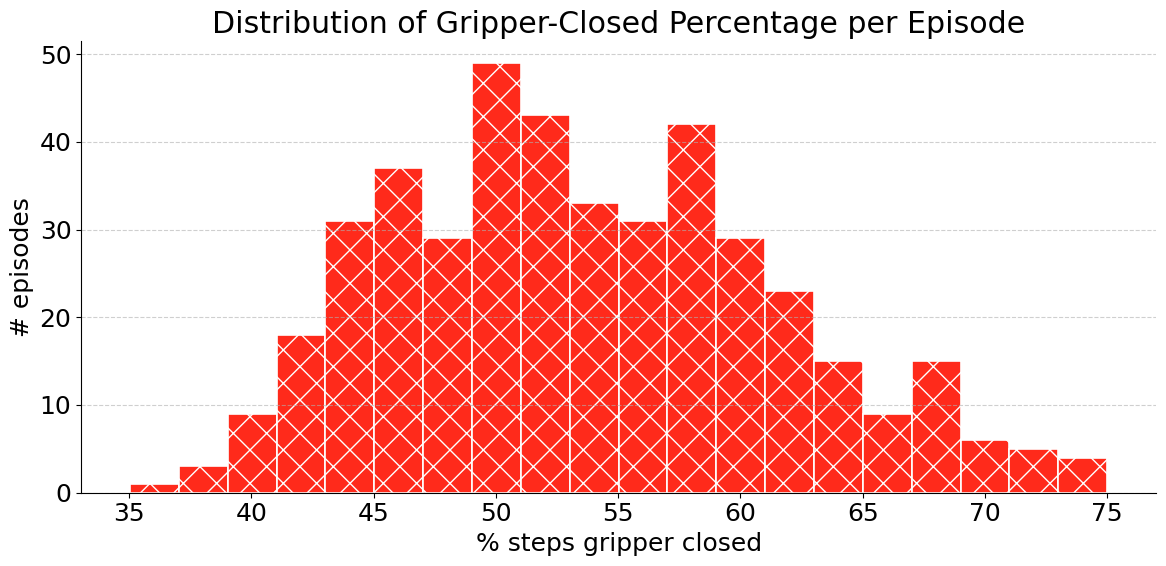

In [37]:
closed_pct = []
for ep in range(total_episodes):
    raw_record = raw_dataset[ep]
    example = tf.train.SequenceExample(); example.ParseFromString(raw_record.numpy())
    context = example.context.feature

    actions = get_actions_from_episode(context)
    closed = np.isclose(actions[:, -1], 1.0)

    closed_pct.append(closed.mean() * 100.0)

p = np.array(closed_pct)

print(f"The average percent of steps gripper is closed: {p.mean():.2f}%")

TEXT = 18
ORANGE = "#FF1100E4"
HATCH = "/\\"

# plot
plt.rcParams.update({'font.size': TEXT, 'figure.facecolor': 'white', 'savefig.facecolor': 'white'})
fig, ax = plt.subplots(figsize=(12, 6))
counts, bins, patches = ax.hist(p, bins=20, edgecolor='white', linewidth=1.2, color=ORANGE)
for bar in patches: bar.set_hatch(HATCH)

ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.spines[['top', 'right']].set_visible(False)
ax.set(xlabel='% steps gripper closed', ylabel='# episodes',
       title='Distribution of Gripper-Closed Percentage per Episode')

plt.tight_layout()
plt.savefig('gripper_closed_distribution.png', dpi=300, bbox_inches='tight')
print('[Success] Saved plot to gripper_closed_distribution.png')